<a href="https://colab.research.google.com/github/marco10507/ml-portfolio/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import gdown
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

file_id = '1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'healthcare-dataset-stroke-data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr
To: /content/healthcare-dataset-stroke-data.csv
100%|██████████| 317k/317k [00:00<00:00, 12.9MB/s]


'healthcare-dataset-stroke-data.csv'

In [33]:
import pandas as pd
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv');
stroke_data.info()
stroke_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [34]:
print("gender unique values:", stroke_data['gender'].unique())
print("ever_married unique values:", stroke_data['ever_married'].unique())
print("work_type unique values:", stroke_data['work_type'].unique())
print("Residence_type unique values:", stroke_data['Residence_type'].unique())
print("smoking_status unique values:", stroke_data['smoking_status'].unique())

gender unique values: ['Male' 'Female' 'Other']
ever_married unique values: ['Yes' 'No']
work_type unique values: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type unique values: ['Urban' 'Rural']
smoking_status unique values: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [35]:
print(stroke_data['stroke'].value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


In [36]:
stroke_data = stroke_data.dropna()
stroke_data = stroke_data[stroke_data['smoking_status'] != 'Unknown'];

In [37]:
print(stroke_data['stroke'].value_counts())

stroke
0    3246
1     180
Name: count, dtype: int64


In [38]:
stroke_data = pd.get_dummies(stroke_data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [39]:
print(stroke_data.columns)

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


In [40]:
features = stroke_data.drop(columns=['id', 'stroke'])
target = stroke_data['stroke'];


X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.3)

In [41]:
gbm = GradientBoostingClassifier(random_state=42)

param_grip = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample" : [0.8, 0.9, 1]
}

search_grid = GridSearchCV(param_grid=param_grip, estimator=gbm, cv=5, n_jobs=-1, scoring='roc_auc')
search_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1]},
             scoring='roc_auc')

In [42]:
print("best params", search_grid.best_params_)
print("best score", search_grid.best_score_)

best params {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
best score 0.7977991228070176


In [43]:
y_pred = search_grid.predict(X_test)

print(classification_report(y_test, y_pred))


feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': search_grid.best_estimator_.feature_importances_
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


print(feature_importance_df)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       969
           1       0.00      0.00      0.00        59

    accuracy                           0.94      1028
   macro avg       0.47      0.50      0.48      1028
weighted avg       0.89      0.94      0.91      1028

                           Feature  Importance
0                              age    0.491691
3                avg_glucose_level    0.292391
4                              bmi    0.097154
1                     hypertension    0.025447
6                      gender_Male    0.023417
17  smoking_status_formerly smoked    0.021417
2                    heart_disease    0.017296
19           smoking_status_smokes    0.014078
5                    gender_Female    0.006442
13         work_type_Self-employed    0.004778
12               work_type_Private    0.003285
18     smoking_status_never smoked    0.002586
10              work_type_Govt_job    0.000014
9              

it seems that model learn to only detect people without strokes. I will performaing oversampling

In [44]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

print('classes counts: \n', y_train.value_counts())


pipeline = Pipeline([
    ('u', RandomUnderSampler(sampling_strategy=(1/3) , random_state=42)),
    ('o', SMOTE(random_state=42))
])


X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print('\nX_resampled: ', X_train_resampled.shape)
print('y_resampled: ', y_train_resampled.shape)

print('resampled classes counts: \n', y_train_resampled.value_counts())

gbm = GradientBoostingClassifier(random_state=42)

param_grip = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample" : [0.8, 0.9, 1]
}

search_grid = GridSearchCV(param_grid=param_grip, estimator=gbm, cv=5, n_jobs=-1, scoring='roc_auc')
search_grid.fit(X_train_resampled, y_train_resampled)

X_train:  (2398, 20)
y_train:  (2398,)
classes counts: 
 stroke
0    2277
1     121
Name: count, dtype: int64

X_resampled:  (726, 20)
y_resampled:  (726,)
resampled classes counts: 
 stroke
0    363
1    363
Name: count, dtype: int64


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1]},
             scoring='roc_auc')

In [45]:
print("train - best params", search_grid.best_params_)
print("train - best score", search_grid.best_score_)

train - best params {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
train - best score 0.9314104167969809


0.0034946689360152625


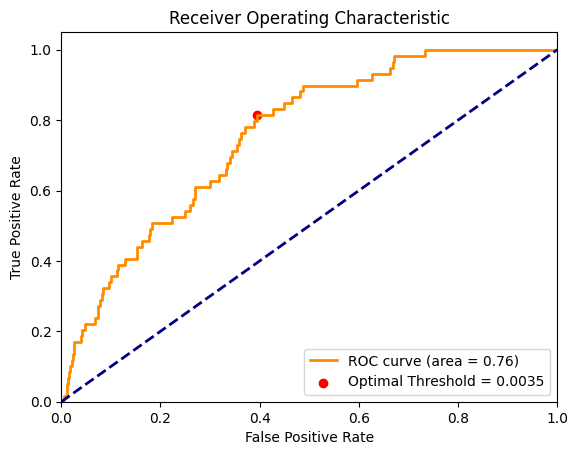

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on the test set
y_prob = search_grid.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Determine the optimal threshold
J = tpr - fpr
optimal_idx = J.argmax()
optimal_threshold = thresholds[optimal_idx]

print(optimal_threshold)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# print("evaluationn with tesst data")
# print(classification_report(y_test, y_pred))